In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import linalg
import pandas as pd

Предположим, что вы хотите продать квартиру и желаете узнать, по какой цене следует продавать, чтобы не продешевить.
Загрузим данные о ценах на нижегородские квартиры (данные в 2017 г. собрал Александр Коротких, за что ему выражаю благодарность):

## 1. Загружаем данные

In [2]:
url = "https://raw.githubusercontent.com/NikolaiZolotykh/MachineLearningCourse/master/flats_subset.csv"
data = pd.read_csv(url)

Таблица содержит данные о более 70 тысяч квартир, выставленных на продажу. Для каждой квартиры указаны ее цена (в тыс. руб.), географические координаты, тип продажи (вторичка или новостройка), количество этажей, тип дома, количество комнат (0 - квартира-студия), номер этажа и общая площадь квартиры (в кв.м).

In [3]:
data.head()

,Price,Lat,Lng,Housing,Floors,House,Rooms,Floor,Area
0,3500.0,56.365696,43.820250,0.0,9.0,Brick,3.0,4.0,60.0
1,4000.0,56.323057,44.007862,0.0,3.0,Brick,3.0,3.0,57.0
2,2150.0,56.267552,43.892107,0.0,5.0,Panel,2.0,1.0,38.0
3,3100.0,56.359963,43.813756,0.0,5.0,Panel,4.0,2.0,59.0
4,3585.0,56.325374,43.937463,0.0,9.0,Panel,2.0,7.0,52.5


## 2. Как цена зависит от площади квартиры

Вначале попробуем с помощью простой линейной регрессии установить связь между ценой `Price` и площадью `Area`

In [4]:
Price = np.array(data['Price'])
Area = np.array(data['Area'])

In [5]:
N = len(Price)
N

71947

По осям отложены `Price` и `Area`.
Видим, что точки расположены вдоль некоторой прямой, идущей из левого нижнего угла в правый верхний.
Чем больше площадь, тем дороже квартира.

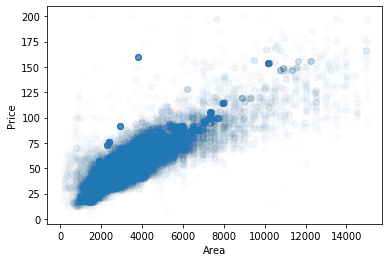

In [6]:
plt.plot(Price, Area, 'o', alpha=.01)
plt.xlabel('Area')
plt.ylabel('Price')
pass

Может следующий график, где мы изобразили только 1000 случайных точек, покажется более красивым:

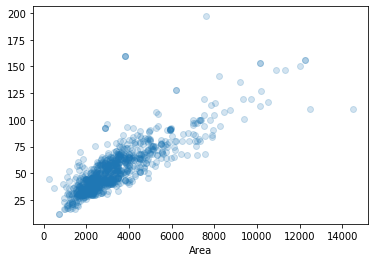

In [7]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(N), size=1000, replace=False)
plt.plot(Price[random_subset], Area[random_subset], 'o', alpha=.2)
plt.xlabel('Area')
pass

Средние значения и стандартные отклонения:

In [8]:
np.mean(Price), np.std(Price)

(3306.7902738960624, 1791.4570895908525)

In [9]:
np.mean(Area), np.std(Area)

(52.51237452569252, 22.07282091962042)

Попробуем аппроксимировать данные.
Попробуем линейную и квадратичную функцию.
Будем искать зависимости
$$
{\rm Price} = \alpha_0 + \alpha_1 {\rm Area}
\qquad
{\rm Price} = \beta_0 + \beta_1 {\rm Area} + \beta_2 {\rm Area}^2
$$

In [10]:
alpha1, alpha0      = np.polyfit(Area, Price, 1)
beta2, beta1, beta0 = np.polyfit(Area, Price, 2)

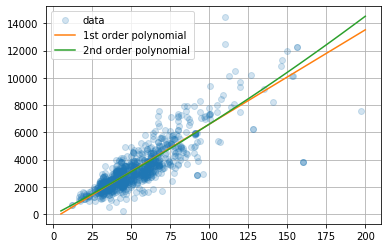

In [11]:
Area_array = np.linspace(np.min(Area), np.max(Area), 100)
plt.plot(Area[random_subset], Price[random_subset], 'o', alpha=0.2, label='data')
plt.plot(Area_array, alpha0 + alpha1*Area_array, label='1st order polynomial')
plt.plot(Area_array, beta0 + beta1*Area_array + beta2*Area_array**2, label='2nd order polynomial')
plt.legend()
plt.grid()
pass

Парабола практически совпадает с прямой

In [12]:
alpha1, alpha0

(69.29633046494646, -332.1245847353684)

In [13]:
beta2, beta1, beta2

(0.06279545986164148, 60.3993009612459, 0.06279545986164148)

Найдем среднеквадратическую ошибку:

In [14]:
np.sqrt(np.sum((alpha0 + alpha1*Area - Price)**2)/N)

932.6027596279054

In [15]:
np.sqrt(np.sum((beta0 + beta1*Area + beta2*Area**2 - Price)**2)/N)

930.6975173945106

## 3. Как цена зависит от количества комнат

Попробуем учесть другой признак - количество комнат.

In [16]:
Rooms = data['Rooms']

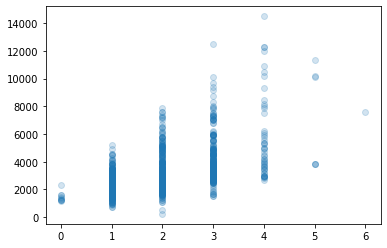

In [17]:
plt.plot(Rooms[random_subset], Price[random_subset], 'o', alpha=.2)
pass

Чем больше комнат - тем дороже квартира. Не удивительно!

Построим модель
$$
{\rm Price} = \gamma_0 + \gamma_1 {\rm Rooms}
$$

In [18]:
gamma1, gamma0 = np.polyfit(Rooms, Price, 1)

In [19]:
np.sqrt(np.sum((gamma0 + gamma1*Rooms - Price)**2)/N)

1487.203304430022

Ошибка стала больше.

# 4. Теперь учтем оба признака

Построим линейную модель
$$
{\rm Price} = \gamma_0 + \gamma_{\rm Area}\cdot{\rm Area} + \gamma_{\rm Rooms}\cdot {\rm Rooms}
$$

In [20]:
AreaRooms = np.vstack((np.ones(N), Area, Rooms)).T

In [21]:
gamma, residuals, rank, sv = linalg.lstsq(AreaRooms, Price)

In [22]:
gamma_0, gamma_Area, gamma_Rooms = gamma
gamma_0, gamma_Area, gamma_Rooms

(-205.18062537691583, 85.29981777268108, -497.9511138594198)

Обратите внимание, что $\gamma_{\rm Rooms}$ отрицательный! Что это означает?

Найдем среднеквадратическую ошибку:

In [23]:
np.sqrt(residuals/N)

886.4393955863346

In [24]:
np.sqrt(np.sum((gamma_0 + gamma_Area*Area + gamma_Rooms*Rooms - Price)**2)/N)

886.4393955863347

In [25]:
def my_predict(Area, Rooms):
    return gamma_0 + gamma_Area*Area + gamma_Rooms*Rooms

Например, сколько "в среднем" стоит 3-комнатная квартира площадью 56 кв.м?

In [26]:
my_predict(56, 3)

3077.7558283149656

Ошибку можно попытаться сделать еще меньше, если задействовать другие признаки и использовать более сложные модели.

## Bonus


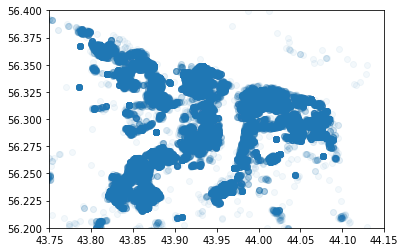

In [27]:
plt.plot(data['Lng'], data['Lat'], 'o', alpha=.05)
plt.xlim((43.75,44.15))
plt.ylim((56.20,56.40))
pass